In [1]:
import xtrack as xt
import numpy as np
import bpmeth
import matplotlib.pyplot as plt

Fitting multipoles
fitting b1...
fitting b2...
Central field in the magnet:  0.4281318567796644
Average field in the magnet:  0.42519216723610626
Rescaling field to match integrated field with design field
Central field in the magnet:  1.0862068936850235
Average field in the magnet:  1.0787486515641858
Creating field expansion...
Creating Hamiltonian...


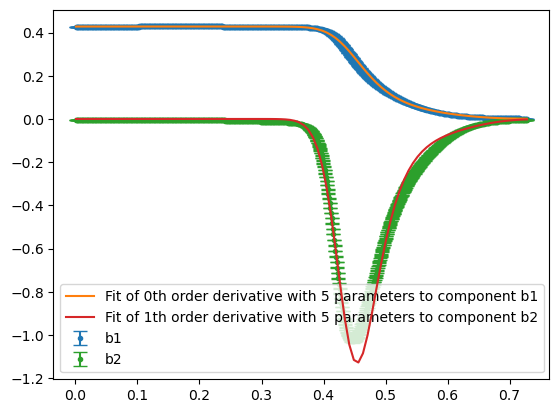

In [2]:
rho = 0.927
dipole_h = 1/rho
dipole_k0 = dipole_h
phi = 60/180*np.pi
l_magn = rho*phi
apt = 0.076
hgap = apt/2
theta_E = 16.45/180*np.pi
theta_E_xsuite = 16.45/180*np.pi#18.195/180*np.pi #18.193/180*np.pi
B = 5.3810e-07
Brho = B*rho
b0 = 1/rho
design_field=b0#*1.001803
fint=0#0.424

data = np.loadtxt("../dipole/ELENA_fieldmap.csv", skiprows=1, delimiter=",")[:, [0,1,2,7,8,9]]
dipole = bpmeth.DipoleFromFieldmap(data, 1/rho, l_magn, design_field=design_field, shape="enge", hgap=apt/2, apt=apt, radius=0.0025, order=2, plot=True, nphi=2)
fringelen = (dipole.smax - dipole.smin - l_magn)/2

In [3]:
xmin, xmax, n_x = -0.4*apt, 0.4*apt, 51
ymin, ymax, n_y = -0.4*apt, 0.4*apt, 51
zmin, zmax, n_z = -0.2*l_magn, 0.2*l_magn, 201
xarr = np.linspace(xmin, xmax, n_x)
yarr = [0]  # np.linspace(ymin, ymax, n_y)
zarr = np.linspace(zmin, zmax, n_z)

data_edge = np.loadtxt("../dipole/ELENA_edge.csv", skiprows=1, delimiter=",")[:, [0,1,2,7,8,9]]
dipole_edge = bpmeth.Fieldmap(data_edge).calc_edge_frame(xarr, yarr, zarr, theta_E, rho, phi, radius=0.005)

/home/silke/miniforge3/envs/xsuite/lib/python3.13/site-packages/pyvista/jupyter/notebook.py:37: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


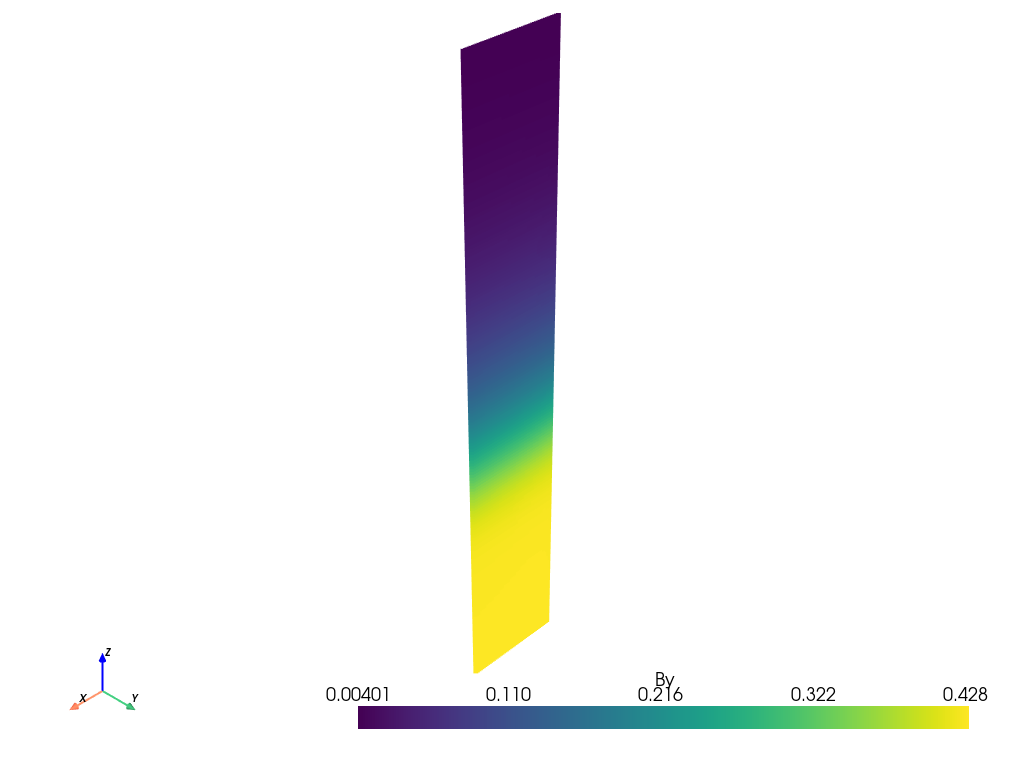

In [4]:
dipole_edge.plot()

In [5]:
zvals, coeffs, coeffsstd = dipole_edge.z_multipoles(2)
b1 = coeffs[:, 0]
b0fieldmap = np.mean(np.sort(b1)[-10:])  # take the last 10 values and average as an estimate of the central field

dipole_edge.rescale(design_field/b0fieldmap)  # rescale such that central field is design field

fieldmap_fint = dipole_edge.calc_Fint(2*hgap, b0)
fieldmap_K0 = dipole_edge.calc_K0(2*hgap, b0, entrance=False)

print("Field integral from fieldmap: ", fieldmap_fint)
print("K0 from fieldmap: ", fieldmap_K0)
print("K0 g**2 b0 = ", fieldmap_K0 * (2*hgap)**2 * b0)

Field integral from fieldmap:  0.42647758552235343
K0 from fieldmap:  0.31240912574349844
K0 g**2 b0 =  0.0019465750920112698


K0gg =  0.0021602418699105193


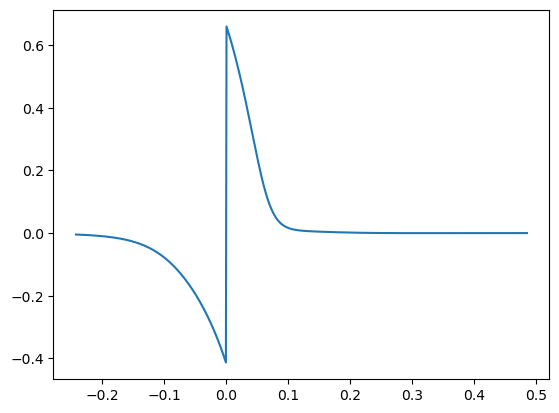

In [6]:
# Calculate the closed orbit fringe field integral (times gap**2, not made dimensionless, also depends on dimensions of field)
# In the curved frame
zvals, coeffs, coeffsstd = dipole.fieldmap.z_multipoles(2)
mask = zvals < 0

zvals = zvals[mask]
b1 = coeffs[:, 0][mask]

scalefactor = b0 / np.max(b1)

K0gg = np.trapezoid((zvals+l_magn/2) * (np.max(b1)*np.heaviside(zvals+l_magn/2, 0.5) - b1) * scalefactor, zvals+l_magn/2)
plt.plot(zvals+l_magn/2, (np.max(b1)*np.heaviside(zvals+l_magn/2, 0.5) - b1) * scalefactor)
print("K0gg = ", K0gg)

In [7]:
class ClosedOrbitDistortion:
    def __init__(self, K0, gap, b0):
        self.K0 = K0
        self.gap = gap
        self.b0 = b0
        
    def track(self, particle):
        xf = particle.x - self.K0*self.gap**2*self.b0
        particle.x = xf

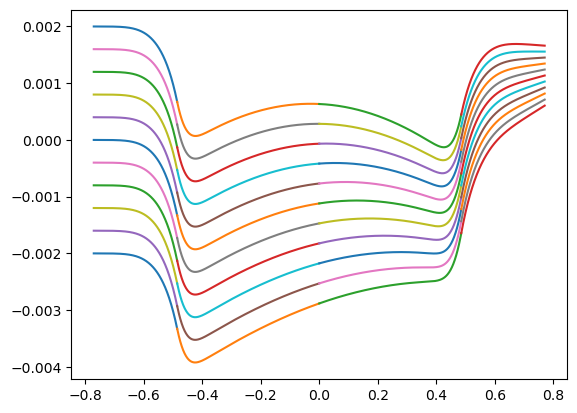

In [8]:
p = xt.Particles(x=np.linspace(-2e-3, 2e-3, 11), y=np.linspace(-2e-3, 2e-3, 11), p0c=0.1, mass0=0.938272, q0=1)

# Run this for the dipole from ELENA
dipole_A_in_str = bpmeth.GeneralVectorPotential(b=(dipole.b_in[0],), hs="0", nphi=2)
dipole_A_in_curv = bpmeth.GeneralVectorPotential(b=(dipole.b_in[0],), hs=f"{dipole_h}", nphi=2)
dipole_A_out_str = bpmeth.GeneralVectorPotential(b=(dipole.b_out[0],), hs="0", nphi=2)
dipole_A_out_curv = bpmeth.GeneralVectorPotential(b=(dipole.b_out[0],), hs=f"{dipole_h}", nphi=2)

dipole_H_in_str = bpmeth.Hamiltonian(fringelen, 0, dipole_A_in_str, s_start=-fringelen-l_magn/2)
dipole_H_in_curv = bpmeth.Hamiltonian(l_magn/2, dipole_h, dipole_A_in_curv, s_start=-l_magn/2)
dipole_H_out_curv = bpmeth.Hamiltonian(l_magn/2, dipole_h, dipole_A_out_curv, s_start=0)
dipole_H_out_str = bpmeth.Hamiltonian(fringelen, 0, dipole_A_out_str, s_start=l_magn/2)

sol_1 = dipole_H_in_str.track(p, return_sol=True)
sol_2 = dipole_H_in_curv.track(p, return_sol=True)
sol_3 = dipole_H_out_curv.track(p, return_sol=True)
sol_4 = dipole_H_out_str.track(p, return_sol=True)

fig, ax = plt.subplots()
for i, _ in enumerate(p.x):
    ax.plot(sol_1[i].t, sol_1[i].y[0])
    ax.plot(sol_2[i].t, sol_2[i].y[0])
    ax.plot(sol_3[i].t, sol_3[i].y[0])
    ax.plot(sol_4[i].t, sol_4[i].y[0])

In [10]:
bb=xt.Bend(length=l_magn, h=dipole_h, k0=dipole_k0, edge_entry_fint=fint, edge_entry_hgap=hgap, model='bend-kick-bend',edge_entry_angle=theta_E_xsuite, edge_exit_angle=theta_E_xsuite, edge_exit_fint=fint, edge_exit_hgap=hgap)
bb.edge_entry_active = 1
bb.edge_exit_active = 1
dd=xt.Drift(length=fringelen)
cod_in = ClosedOrbitDistortion(fieldmap_K0, 2*hgap, b0)
cod_out = ClosedOrbitDistortion(-fieldmap_K0, 2*hgap, b0)

line = xt.Line([dd, cod_in, bb, cod_out, dd])
line.particle_ref = xt.Particles(p0c=0.1, mass0=0.938272, q0=1)

tw = line.twiss4d(betx=0, bety=0, x=0, include_collective=True)

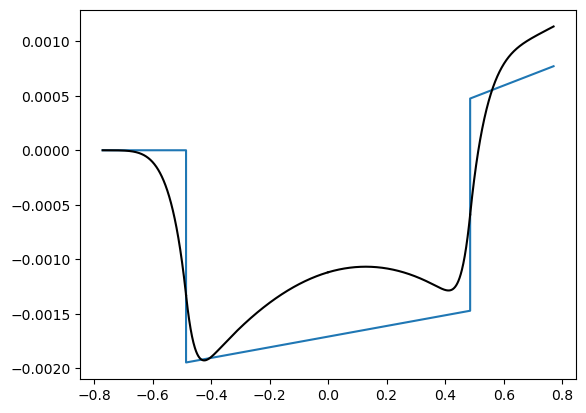

In [11]:
fig, ax = plt.subplots()
ax.plot(tw.s-l_magn/2-fringelen, tw.x, label='x')
    
ax.plot(sol_1[5].t, sol_1[5].y[0], color="black")
ax.plot(sol_2[5].t, sol_2[5].y[0], color="black")
ax.plot(sol_3[5].t, sol_3[5].y[0], color="black")
ax.plot(sol_4[5].t, sol_4[5].y[0], color="black")


In [55]:
bb=xt.Bend(length=l_magn, h=dipole_h, k0=dipole_k0, edge_entry_fint=fint, edge_entry_hgap=hgap, model='bend-kick-bend',edge_entry_angle=theta_E_xsuite, edge_exit_angle=theta_E_xsuite, edge_exit_fint=fint, edge_exit_hgap=hgap)
bb.edge_entry_active = 1
bb.edge_exit_active = 1
dd=xt.Drift(length=fringelen)
line = xt.Line([dd, bb, dd])
line.particle_ref = xt.Particles(p0c=1.0, mass0=0.9382720813)
line.build_tracker()
p0=line.build_particles(x=[0.00])
mat_xsuite=line.compute_one_turn_matrix_finite_differences(p0,include_collective=True)['R_matrix']
print(mat_xsuite)
print(bb)

[[ 0.67855929  1.00991354  0.          0.          0.          0.60987217]
 [-0.53426087  0.67855929  0.          0.          0.          1.01365766]
 [ 0.          0.          0.61303353  1.15902565  0.          0.        ]
 [ 0.          0.         -0.53854708  0.61303353  0.          0.        ]
 [-1.01365766 -0.60987217  0.          0.          1.          0.42175732]
 [ 0.          0.          0.          0.          0.          1.        ]]
Bend(length=0.971, k0=1.08, k1=0, h=1.08, k0_from_h=False, model='bend-kick-bend', knl=array([0., 0., 0., 0., 0., 0.]), ksl=array([0., 0., 0., 0., 0., 0.]), edge_entry_active=np.int64(1), edge_exit_active=np.int64(1), edge_entry_model='linear', edge_exit_model='linear', edge_entry_angle=0.287, edge_exit_angle=0.287, edge_entry_angle_fdown=0, edge_exit_angle_fdown=0, edge_entry_fint=0, edge_exit_fint=0, edge_entry_hgap=0.038, edge_exit_hgap=0.038, shift_x=0, shift_y=0, rot_s_rad=0)


In [56]:
bb=xt.Bend(length=1.0, h=1, k0=1, model='mat-kick-mat')
bb.edge_entry_active = 1
bb.edge_exit_active = 0
dd=xt.Drift(length=fringelen)
line = xt.Line([dd, bb, dd])
line.particle_ref = xt.Particles(p0c=1.0, mass0=0.9382720813)
line.build_tracker()
p0=line.build_particles(x=[0.0])
mat=line.compute_one_turn_matrix_finite_differences(p0,include_collective=True)['R_matrix']
print(mat)
print(bb)

[[ 0.4187939   0.97996448  0.          0.          0.          0.5812061 ]
 [-0.84147098  0.4187939   0.          0.          0.          0.84147098]
 [ 0.          0.          1.          1.2888      0.          0.        ]
 [ 0.          0.          0.          1.          0.          0.        ]
 [-0.84147098 -0.5812061   0.          0.          1.          0.44486831]
 [ 0.          0.          0.          0.          0.          1.        ]]
Bend(length=1, k0=1, k1=0, h=1, k0_from_h=False, model='mat-kick-mat', knl=array([0., 0., 0., 0., 0., 0.]), ksl=array([0., 0., 0., 0., 0., 0.]), edge_entry_active=np.int64(1), edge_exit_active=np.int64(0), edge_entry_model='linear', edge_exit_model='linear', edge_entry_angle=0, edge_exit_angle=0, edge_entry_angle_fdown=0, edge_exit_angle_fdown=0, edge_entry_fint=0, edge_exit_fint=0, edge_entry_hgap=0, edge_exit_hgap=0, shift_x=0, shift_y=0, rot_s_rad=0)


In [57]:
bb=xt.Bend(length=1.0, h=1, k0=1, edge_entry_fint=0.1, edge_entry_hgap=1, edge_exit_fint=0.1, edge_exit_hgap=1, edge_entry_model=1)
bb.edge_entry_active = 1
bb.edge_exit_active = 0
dd = xt.Drift(length=fringelen)
line = xt.Line([dd, bb, dd])
line.particle_ref = xt.Particles(p0c=1.0, mass0=0.9382720813)
line.build_tracker()
p0=line.build_particles(x=[0.00])
mat=line.compute_one_turn_matrix_finite_differences(p0,include_collective=True)['R_matrix']
print(mat)
print(bb)

[[ 0.4187939   0.97996448  0.          0.          0.          0.5812061 ]
 [-0.84147098  0.4187939   0.          0.          0.          0.84147098]
 [ 0.          0.          1.23198136  1.32229811  0.          0.        ]
 [ 0.          0.          0.20271004  1.02927133  0.          0.        ]
 [-0.84147098 -0.5812061   0.          0.          1.          0.44486831]
 [ 0.          0.          0.          0.          0.          1.        ]]
Bend(length=1, k0=1, k1=0, h=1, k0_from_h=False, model='adaptive', knl=array([0., 0., 0., 0., 0., 0.]), ksl=array([0., 0., 0., 0., 0., 0.]), edge_entry_active=np.int64(1), edge_exit_active=np.int64(0), edge_entry_model='full', edge_exit_model='linear', edge_entry_angle=0, edge_exit_angle=0, edge_entry_angle_fdown=0, edge_exit_angle_fdown=0, edge_entry_fint=0.1, edge_exit_fint=0.1, edge_entry_hgap=1, edge_exit_hgap=1, shift_x=0, shift_y=0, rot_s_rad=0)


In [58]:
ss = np.linspace(0, dipole.smax, 1000)
integral = np.trapezoid([dipole.b_out[1].subs({dipole.s:sss}) for sss in ss], ss)
scalefactor = np.abs(dipole_k0*np.tan(theta_E)/ integral)
scalefactor

1.21495088422205

In [59]:

dipole_A_in_str = bpmeth.GeneralVectorPotential(b=("0",dipole.b_in[1]*scalefactor), hs="0", nphi=2)
dipole_A_in_curv = bpmeth.GeneralVectorPotential(b=(f"{dipole_k0}",dipole.b_in[1]*scalefactor), hs=f"{dipole_h}", nphi=2)
dipole_A_out_str = bpmeth.GeneralVectorPotential(b=("0",dipole.b_out[1]*scalefactor), hs="0", nphi=2)
dipole_A_out_curv = bpmeth.GeneralVectorPotential(b=(f"{dipole_k0}",dipole.b_out[1]*scalefactor), hs=f"{dipole_h}", nphi=2)

# dipole_A_in_str = bpmeth.GeneralVectorPotential(b=(dipole.b_in[0],dipole.b_in[1]*scalefactor), hs="0", nphi=2)
# dipole_A_in_curv = bpmeth.GeneralVectorPotential(b=(dipole.b_in[0],dipole.b_in[1]*scalefactor), hs=f"{dipole_h}", nphi=2)
# dipole_A_out_str = bpmeth.GeneralVectorPotential(b=(dipole.b_out[0],dipole.b_out[1]*scalefactor), hs="0", nphi=2)
# dipole_A_out_curv = bpmeth.GeneralVectorPotential(b=(dipole.b_out[0],dipole.b_out[1]*scalefactor), hs=f"{dipole_h}", nphi=2)

# dipole_A_in_str = bpmeth.DipoleVectorPotential(b1=dipole.b_in[0], curv=0)
# dipole_A_in_curv = bpmeth.DipoleVectorPotential(b1=dipole.b_in[0], curv=dipole_h)
# dipole_A_out_str = bpmeth.DipoleVectorPotential(b1=dipole.b_out[0], curv=0)
# dipole_A_out_curv = bpmeth.DipoleVectorPotential(b1=dipole.b_out[0], curv=dipole_h)

dipole_H_in_str = bpmeth.Hamiltonian(fringelen, 0, dipole_A_in_str, s_start=-fringelen-l_magn/2)
dipole_H_in_curv = bpmeth.Hamiltonian(l_magn/2, dipole_h, dipole_A_in_curv, s_start=-l_magn/2)
dipole_H_out_curv = bpmeth.Hamiltonian(l_magn/2, dipole_h, dipole_A_out_curv, s_start=0)
dipole_H_out_str = bpmeth.Hamiltonian(fringelen, 0, dipole_A_out_str, s_start=l_magn/2)

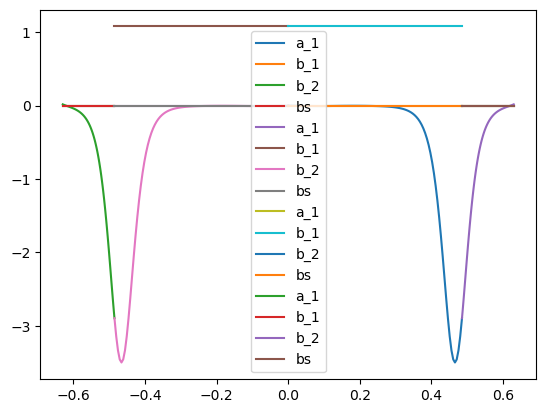

In [60]:
fig, ax = plt.subplots()
dipole_A_in_str.plot_components(smin=-fringelen-l_magn/2, smax=-l_magn/2, ax=ax)
dipole_A_in_curv.plot_components(smin=-l_magn/2, smax=0, ax=ax)
dipole_A_out_curv.plot_components(smin=0, smax=l_magn/2, ax=ax)
dipole_A_out_str.plot_components(smin=l_magn/2, smax=fringelen+l_magn/2, ax=ax)

In [61]:
line = xt.Line([dipole_H_in_str, dipole_H_in_curv, dipole_H_out_curv, dipole_H_out_str])
line.particle_ref = xt.Particles(p0c=1.0, mass0=0.9382720813)
line.build_tracker()
p0=line.build_particles(x=[0.0])
mat_mydipole=line.compute_one_turn_matrix_finite_differences(p0,include_collective=True)['R_matrix']


In [62]:
print(mat_mydipole)
print(mat_xsuite)


[[ 0.67461916  1.02213557  0.          0.          0.          0.60592998]
 [-0.60005967  0.67956236  0.          0.          0.          0.96630711]
 [ 0.          0.          0.61523243  1.1459961   0.          0.        ]
 [ 0.          0.         -0.52311216  0.60798701  0.          0.        ]
 [-1.01016755 -0.61141546  0.          0.          1.          0.42136476]
 [ 0.          0.          0.          0.          0.          1.        ]]
[[ 0.67855929  1.00991354  0.          0.          0.          0.60987217]
 [-0.53426087  0.67855929  0.          0.          0.          1.01365766]
 [ 0.          0.          0.61303353  1.15902565  0.          0.        ]
 [ 0.          0.         -0.53854708  0.61303353  0.          0.        ]
 [-1.01365766 -0.60987217  0.          0.          1.          0.42175732]
 [ 0.          0.          0.          0.          0.          1.        ]]
